# Cats and Dogs Image Classification using CNN
Binary classification between cats and dogs.

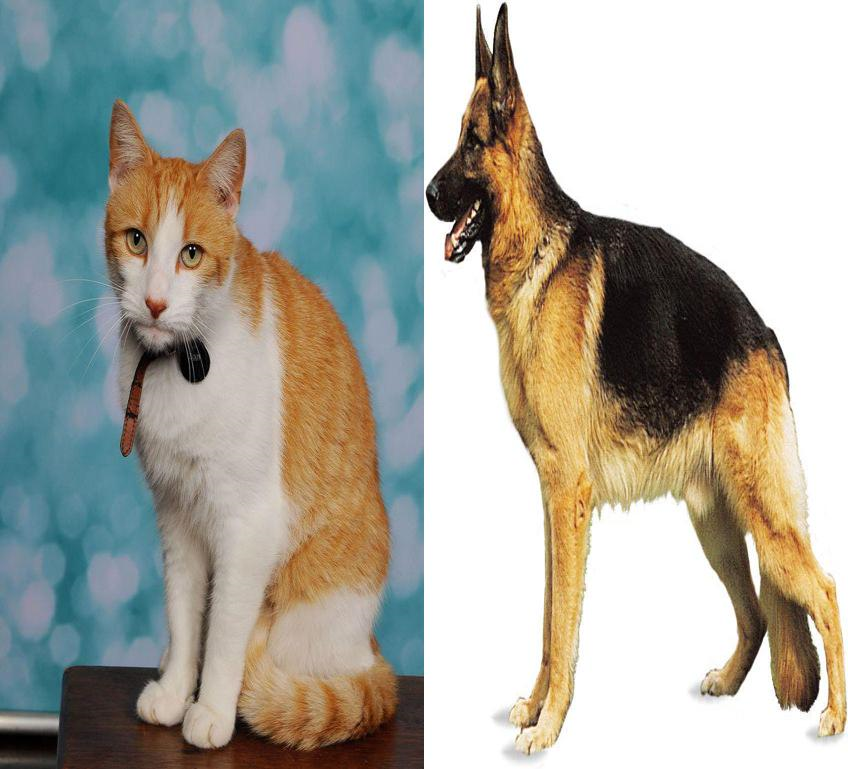

## About Dataset

Over a 1000 images of cats and dogs scraped off of google images. The problem statement is to build a model that can classify between a cat and a dog in an image as accurately as possible.

Image sizes range from roughly 100x100 pixels to 2000x1000 pixels.

Image format is jpeg.

Duplicates have been removed.

## Import Necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, ResNet50V2, EfficientNetB0, Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras import regularizers, backend
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet50v2_preprocess_input


import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)

In [2]:
# Seed for reproducibility
seed = 42

In [3]:
# Set tensorflow to only announce errors
tf.get_logger().setLevel('ERROR')

In [4]:
train_dir = "kaggle/input/cats-and-dogs-image-classification/train"
test_dir = "kaggle/input/cats-and-dogs-image-classification/test"

print("Training Folder path:  ",train_dir)
print("Testing Folder path:   ",test_dir)

Training Folder path:   kaggle/input/cats-and-dogs-image-classification/train
Testing Folder path:    kaggle/input/cats-and-dogs-image-classification/test


In [5]:
# Find the names of cateogries we will be classifying
categories = os.listdir(train_dir)
categories

['cats', 'dogs']

## Useful functions

In [6]:
def create_generators(train_dir, test_dir, preprocessing_function=None):
    ''' Create data generators
        train_dir: Training directory
        test_dir: Testing directory
        pre_processing_functions: Defaulta to None
    '''
    img_height, img_width = 224, 224
    batch_size = 16

    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    if (preprocessing_function is not None):
        train_datagen.preprocessing_function = preprocessing_function
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        classes=['cats', 'dogs'],
        shuffle=True,
        subset='training',
        seed=seed
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        classes=['cats', 'dogs'],
        shuffle=False,
        subset='validation',
        seed=seed
     )
       
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        classes=['cats', 'dogs'],
        seed=seed
    )
    
    return train_generator, validation_generator, test_generator

def plot_sample_images(generator, num_samples_per_class=6, predicted_classes = None):
    ''' Plot some random images
        generator: Data generatoe
        num_samples_per_class: Defaulta to 6
        predicted_classes: Defaults to None
    '''
    
    images, labels = next(generator)

    dog_indices = [i for i, label in enumerate(labels) if label == 1]  # Dog class index
    cat_indices = [i for i, label in enumerate(labels) if label == 0]  # Cat class index

    # Randomly select 6 dog images and 6 cat images
    selected_dog_indices = random.sample(dog_indices, num_samples_per_class)
    selected_cat_indices = random.sample(cat_indices, num_samples_per_class)

    indices_dict = {"cat": selected_cat_indices, "dog": selected_dog_indices}

    # Output the cats sample followed by the dogs
    for key, value in indices_dict.items():
        plt.figure(figsize=(15, 15))
        for i, animal_index in enumerate(value):
            plt.subplot(4, 3, i + 1)
            img = images[animal_index]
            plt.imshow(img)
            
            if (predicted_classes is None):
                plt.title(key)
            else:
                pred_label = 'dog' if predicted_classes[animal_index] == 1 else 'cat'
                plt.title("actual: {}\npredicted: {}\n".format(key, pred_label))
                             
            plt.axis('off')

        plt.tight_layout() 
        plt.show() 

def get_callbacks(model_name, early_stopping_patience=5):
    ''' Generate checkpoint, reduce learning rate and early stopping callbacks
        model_name: Name of the model
        early_stopping_patience: Defaulta to 5
    '''
    checkpointer = ModelCheckpoint(filepath='dogs_and_cats_{}'.format(model_name),
                            monitor='val_accuracy', verbose = 1,
                            save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                                      factor = 0.1,
                                      patience = 2, 
                                      min_lr=0.00001,
                                      verbose = 1)

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stopping_patience, mode='max', verbose=1)
        
    return [checkpointer,reduce_lr, early_stopping]
    
def plot_loss_accuracy(model_name, history):
    '''Output loss and accuracy curve
        model_name: Name of the model
        history: History results from fit
    '''   
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy for {}'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show();

    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss for {}'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show();
    
def build_custom_model(train_generator, validation_generator, test_generator, img_height=224, img_width=224, epochs=30):
    ''' Build a custom model
        train_generator: Training generator
        validation_generator: Val generator
        test_generator: Testing generator
        img_height: Defaults to 224
        img_width: Defaults to 224
        epochs: Defaulta to 30
    '''

    # Clear the session before modelling
    backend.clear_session()
    set_seed(seed)
    
    custom_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu', kernel_initializer='he_uniform'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model_name = 'Custom Model'
    custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = custom_model.fit(train_generator, epochs=epochs, validation_data=validation_generator,
                              callbacks=get_callbacks(model_name, early_stopping_patience=8))
    
    # Plot loss and accuracy curves
    plot_loss_accuracy(model_name, history)
        
    # To load the model architecture and weights in a new session:
    loaded_model = tf.keras.models.load_model('dogs_and_cats_{}'.format(model_name))

    # Compile the loaded model
    loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    val_results, _ = make_confusion_matrix(loaded_model, validation_generator, title='Validation')
    
    test_results, _ = make_confusion_matrix(loaded_model, test_generator, title='Test')
        
    return loaded_model, val_results, test_results


def make_confusion_matrix(model, generator,figsize=None,title=None):
    ''' This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
        model: Model to use
        generator: Data generator
        figsize: Default to None
        title: Default to None
    '''
    ## Lets make predictions to generate a confusion matrix
    predictions = model.predict(generator)

    #Let's predict using default threshold
    y_pred = (predictions > 0.5)         
    cf = confusion_matrix(generator.classes, y_pred);
    
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_labels = ["{}\n".format(value) for value in group_names]
    group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    #if it is a binary confusion matrix, show some more stats
    if len(cf)==2:
        #Metrics for Binary Confusion Matrices
        accuracy  = accuracy_score(generator.classes, y_pred)
        precision = precision_score(generator.classes, y_pred)
        recall    = recall_score(generator.classes, y_pred)
        if ((recall + precision) != 0):
            f1_score  = 2*precision*recall / (precision + recall)
        else:
            f1_score = 0
            
        stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                        accuracy,precision,recall,f1_score)
            
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap='Blues',cbar=True,xticklabels=categories,yticklabels=categories)
           
    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)
    
    if title:
        plt.title(title)
        
    plt.show();
    
    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": accuracy, "Recall": recall, "Precision": precision, "F1": f1_score,},
        index=[0],
    )

    return df_perf, y_pred

def get_performance_results(results, dataset_name):
    ''' Generate model performance dataframes
        results: Performance resutls
        dataset_name: Name of performance dataset
    '''
    # Performance comparison
    models_comp_df = pd.concat(
        list(results.values()),
        axis=1,
    )
    models_comp_df.columns = list(results.keys())
    models_comp_df = models_comp_df.style.set_caption('{} performance comparison'.format(dataset_name))\
                                                     .set_table_styles([{
                                                         'selector': 'caption',
                                                         'props': 'text-align: center;font-size: 1.5em;font-weight:bold;'
                                                     }], overwrite=False)
    return models_comp_df
    
def set_seed(seed):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

## Transfer Modeling classes

In [7]:
class BaseTransferModel(object):
    def __init__(self, shape=(224, 224, 3), weights='imagenet', processing_function=None):
        self.weights = weights
        self.shape = shape
        self.model_name = self.__class__.__name__
        self.processing_function = processing_function
        self.transfer_model = None
        self.build_cnn_model()
        self.val_results = []
        self.test_results = []
        self.y_pred_test = None

    def make_layers_untrainable(self, model):
        if (model is not None):
            for layer in model.layers:
                layer.trainable = False

    def create_model(self):
        return None

    def get_processing_function(self):
            return None
        
    def build_cnn_model(self):
        # Clear the session before modelling
        backend.clear_session()
        set_seed(seed)
        
        model = None
        base_model = self.create_model()
    
        if (base_model is not None):
            self.make_layers_untrainable(base_model)
            model = Sequential([
                        base_model,
                        Flatten(),
                        Dense(256, activation='relu', kernel_initializer='he_uniform'),
                        Dropout(0.3),
                        Dense(1, activation='sigmoid')])
            self.transfer_model = model

        return self.transfer_model

    def build_transfer_model(self, epochs=10):
        print(f"Training {self.model_name}...")
        transfer_model = self.transfer_model
        train_generator, validation_generator, test_generator = create_generators(train_dir, test_dir, 
                                                                                preprocessing_function=self.processing_function)
        
        transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = transfer_model.fit(train_generator, epochs=epochs, validation_data=validation_generator,
                               callbacks=get_callbacks(self.model_name))

        plot_loss_accuracy(self.model_name, history)

        # To load the model architecture and weights in a new session:
        loaded_model = tf.keras.models.load_model('dogs_and_cats_{}'.format(self.model_name))

        # Compile the loaded model
        loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        print(f"Evaluating {self.model_name}...")
        self.val_results, _ = make_confusion_matrix(loaded_model, validation_generator, title='Validation')
        self.test_results, self.y_pred_test = make_confusion_matrix(loaded_model, test_generator, title='Test')

class VGG19Model(BaseTransferModel):
    def __init__(self, shape=(224, 224, 3), weights='imagenet'):
        super(VGG19Model, self).__init__(processing_function=vgg19_preprocess_input)
        
    def create_model(self):
        return VGG19(include_top=False, weights=self.weights, input_shape=self.shape)
    
class InceptionModel(BaseTransferModel):
    def create_model(self):
        return InceptionV3(include_top=False, weights=self.weights, input_shape=self.shape)
    
class XceptionModel(BaseTransferModel):
    def create_model(self):
        return Xception(include_top=False, weights=self.weights, input_shape=self.shape)

In [8]:
# Stash the model validation performance
validation_results = {}

# Stash the model test performance
testing_results = {}

# Dictionary of all the models
processed_models = {}

In [9]:
# Create data generators for custom model
train_generator, validation_generator, test_generator = create_generators(train_dir, test_dir)

Found 447 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


## Let's plot some sample images

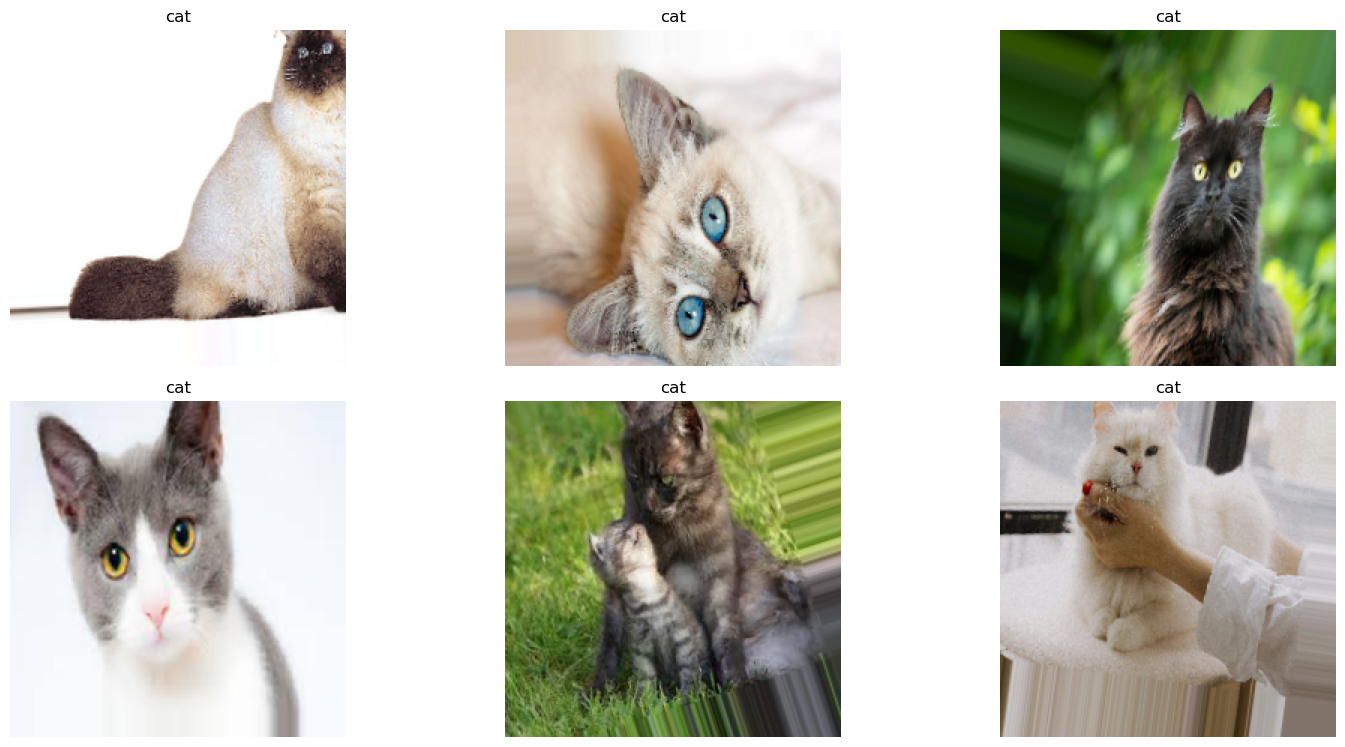

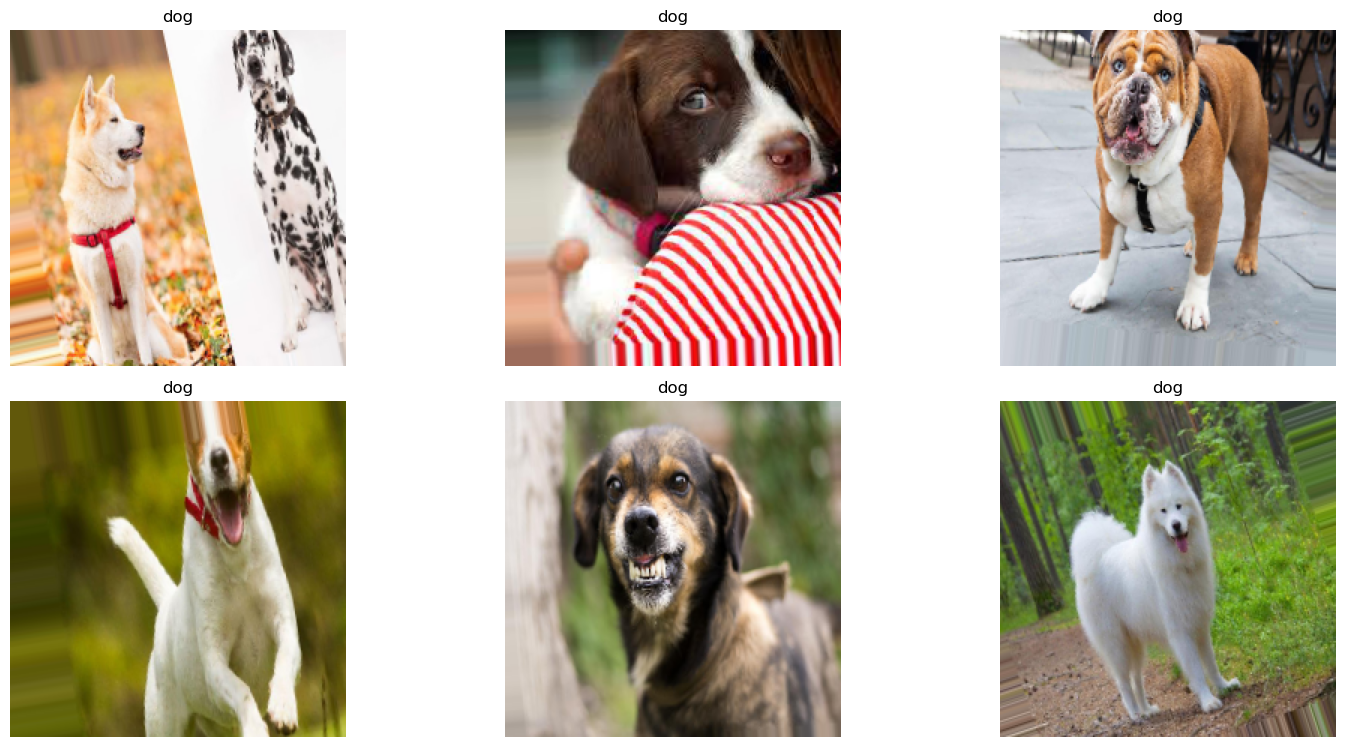

In [10]:
plot_sample_images(train_generator)

## Build a custom model

Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.5011
Epoch 1: val_accuracy improved from -inf to 0.51818, saving model to dogs_and_cats_Custom Model


28/28 [==============================] - 23s 783ms/step - loss: 0.7103 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5182 - lr: 0.0010
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5011
Epoch 2: val_accuracy did not improve from 0.51818
28/28 [==============================] - 19s 676ms/step - loss: 0.6933 - accuracy: 0.5011 - val_loss: 0.6924 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5213
Epoch 3: val_accuracy improved from 0.51818 to 0.53636, saving model to dogs_and_cats_Custom Model


28/28 [==============================] - 20s 725ms/step - loss: 0.6909 - accuracy: 0.5213 - val_loss: 0.6737 - val_accuracy: 0.5364 - lr: 0.0010
Epoch 4/30
28/28 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5526
Epoch 4: val_accuracy improved from 0.53636 to 0.64545, saving model to dogs_and_cats_Custom Model


28/28 [==============================] - 20s 715ms/step - loss: 0.6937 - accuracy: 0.5526 - val_loss: 0.6666 - val_accuracy: 0.6455 - lr: 0.0010
Epoch 5/30
28/28 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.5459
Epoch 5: val_accuracy did not improve from 0.64545
28/28 [==============================] - 19s 677ms/step - loss: 0.6900 - accuracy: 0.5459 - val_loss: 0.6739 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 6/30
28/28 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5749
Epoch 6: val_accuracy did not improve from 0.64545

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
28/28 [==============================] - 19s 676ms/step - loss: 0.6923 - accuracy: 0.5749 - val_loss: 0.6912 - val_accuracy: 0.5545 - lr: 0.0010
Epoch 7/30
28/28 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5503
Epoch 7: val_accuracy did not improve from 0.64545
28/28 [==============================] - 19s 683ms/s

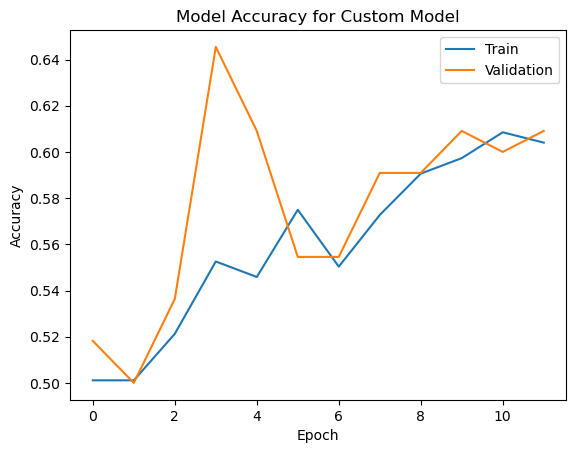

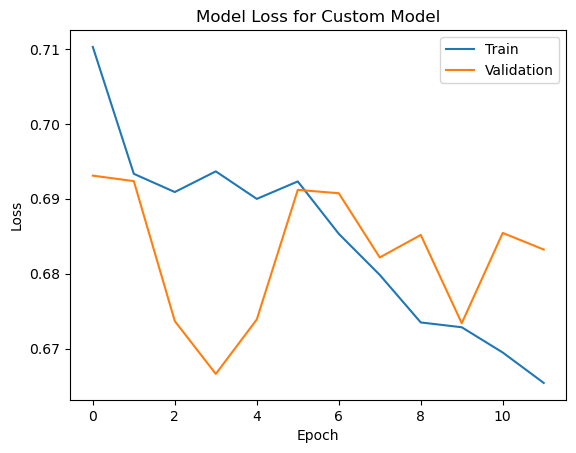

7/7 [==============================] - 2s 285ms/step


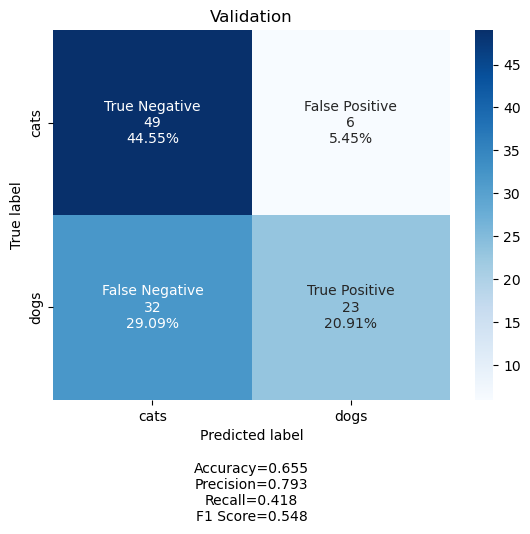

9/9 [==============================] - 2s 201ms/step


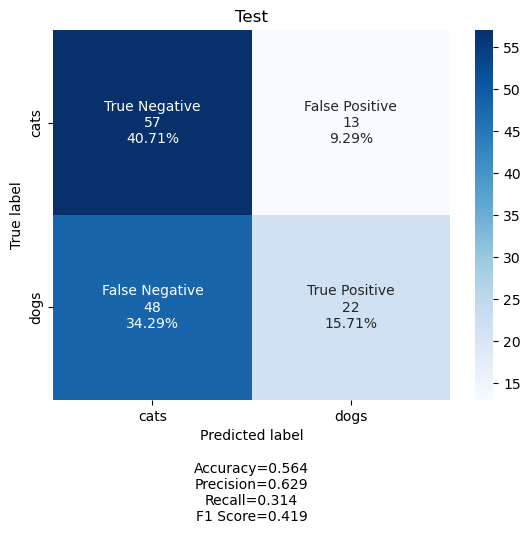

In [11]:
# Build Custom mode
model_name = 'Custom Model'
model, val_results, test_results = build_custom_model(train_generator, validation_generator, test_generator, epochs=30)
processed_models[model_name] = model

In [12]:
# Stash results
testing_results[model_name] = test_results.T
validation_results[model_name] = val_results.T

- The loss for validation stagnated after epoch 6
- Overall validation accuracy of .618 and test accuracy of .643. Not great so let's test some transfer learning models.

## Transfer Learning
Transfer learning with pretrained models involves utilizing a pre-trained neural network, initially developed for one task or dataset, as a foundation for solving a different but related task. By leveraging the learned features and representations from the pretrained model, this approach enables the efficient adaptation of the model to new tasks with potentially limited data. The lower layers of the pretrained model capture general features applicable to various tasks, while the higher layers, which are task-specific, can be fine-tuned or replaced to suit the new problem, thus accelerating training and often improving performance.

### VGG19 Model
https://keras.io/api/applications/vgg/

Training VGG19Model...
Found 447 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 1.4595 - accuracy: 0.6532
Epoch 1: val_accuracy improved from -inf to 0.75455, saving model to dogs_and_cats_VGG19Model


28/28 [==============================] - 47s 2s/step - loss: 1.4595 - accuracy: 0.6532 - val_loss: 0.5684 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.7852
Epoch 2: val_accuracy improved from 0.75455 to 0.82727, saving model to dogs_and_cats_VGG19Model


28/28 [==============================] - 46s 2s/step - loss: 0.5991 - accuracy: 0.7852 - val_loss: 0.3766 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 0.3946 - accuracy: 0.8098
Epoch 3: val_accuracy did not improve from 0.82727
28/28 [==============================] - 45s 2s/step - loss: 0.3946 - accuracy: 0.8098 - val_loss: 0.4152 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 4/30
28/28 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.8523
Epoch 4: val_accuracy did not improve from 0.82727

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
28/28 [==============================] - 45s 2s/step - loss: 0.3191 - accuracy: 0.8523 - val_loss: 0.3892 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 5/30
28/28 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8747
Epoch 5: val_accuracy did not improve from 0.82727
28/28 [==============================] - 46s 2s/step - loss: 


Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
28/28 [==============================] - 49s 2s/step - loss: 0.2418 - accuracy: 0.8814 - val_loss: 0.3852 - val_accuracy: 0.8455 - lr: 1.0000e-04
Epoch 7/30
28/28 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.8993
Epoch 7: val_accuracy did not improve from 0.84545
28/28 [==============================] - 44s 2s/step - loss: 0.2346 - accuracy: 0.8993 - val_loss: 0.4060 - val_accuracy: 0.8182 - lr: 1.0000e-05
Epoch 8/30
28/28 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9016
Epoch 8: val_accuracy improved from 0.84545 to 0.86364, saving model to dogs_and_cats_VGG19Model


28/28 [==============================] - 47s 2s/step - loss: 0.2433 - accuracy: 0.9016 - val_loss: 0.3269 - val_accuracy: 0.8636 - lr: 1.0000e-05
Epoch 9/30
28/28 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9060
Epoch 9: val_accuracy improved from 0.86364 to 0.88182, saving model to dogs_and_cats_VGG19Model


28/28 [==============================] - 48s 2s/step - loss: 0.2238 - accuracy: 0.9060 - val_loss: 0.2871 - val_accuracy: 0.8818 - lr: 1.0000e-05
Epoch 10/30
28/28 [==============================] - ETA: 0s - loss: 0.2332 - accuracy: 0.9150
Epoch 10: val_accuracy did not improve from 0.88182
28/28 [==============================] - 44s 2s/step - loss: 0.2332 - accuracy: 0.9150 - val_loss: 0.3532 - val_accuracy: 0.8727 - lr: 1.0000e-05
Epoch 11/30
28/28 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9105
Epoch 11: val_accuracy did not improve from 0.88182

Epoch 11: ReduceLROnPlateau reducing learning rate to 1e-05.
28/28 [==============================] - 44s 2s/step - loss: 0.2236 - accuracy: 0.9105 - val_loss: 0.3747 - val_accuracy: 0.8273 - lr: 1.0000e-05
Epoch 12/30
28/28 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9306
Epoch 12: val_accuracy did not improve from 0.88182
28/28 [==============================] - 44s 2s/step - loss

Evaluating VGG19Model...
7/7 [==============================] - 9s 1s/step


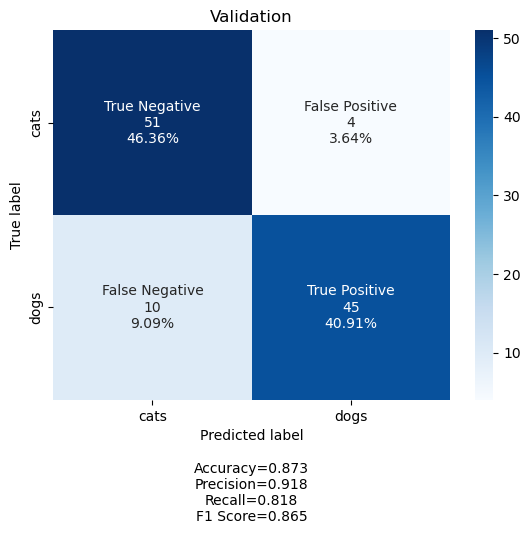

9/9 [==============================] - 10s 1s/step


In [13]:
# Build VGG19 model
model = VGG19Model()
model.build_transfer_model(epochs=30)
processed_models[model.model_name] = model

In [14]:
# Stash results
testing_results[model.model_name] = model.test_results.T
validation_results[model.model_name] = model.val_results.T

- The accuracy and loss curves track well for training and validation.
- Overall validation accuracy of .873 and test accuracy of .807. Big improvement from the custom model let look at some other transfer learning models.

### Inception Model
https://keras.io/api/applications/inceptionv3/

Training InceptionModel...
Found 447 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 7.5800 - accuracy: 0.8076
Epoch 1: val_accuracy improved from -inf to 0.92727, saving model to dogs_and_cats_InceptionModel


28/28 [==============================] - 41s 1s/step - loss: 7.5800 - accuracy: 0.8076 - val_loss: 2.3794 - val_accuracy: 0.9273 - lr: 0.0010
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 2.1268 - accuracy: 0.9150
Epoch 2: val_accuracy improved from 0.92727 to 0.95455, saving model to dogs_and_cats_InceptionModel


28/28 [==============================] - 39s 1s/step - loss: 2.1268 - accuracy: 0.9150 - val_loss: 0.4303 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.9575
Epoch 3: val_accuracy did not improve from 0.95455
28/28 [==============================] - 58s 2s/step - loss: 0.8505 - accuracy: 0.9575 - val_loss: 2.1979 - val_accuracy: 0.9455 - lr: 0.0010
Epoch 4/30
28/28 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.9597
Epoch 4: val_accuracy did not improve from 0.95455

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
28/28 [==============================] - 54s 2s/step - loss: 0.5988 - accuracy: 0.9597 - val_loss: 0.4931 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 5/30
28/28 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.9642
Epoch 5: val_accuracy did not improve from 0.95455
28/28 [==============================] - 53s 2s/step - loss: 


Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
28/28 [==============================] - 74s 3s/step - loss: 0.3077 - accuracy: 0.9732 - val_loss: 0.5113 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 7/30
28/28 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.9642
Epoch 7: val_accuracy did not improve from 0.98182
28/28 [==============================] - 69s 2s/step - loss: 0.5012 - accuracy: 0.9642 - val_loss: 0.5784 - val_accuracy: 0.9545 - lr: 1.0000e-05
Epoch 8/30
28/28 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9866
Epoch 8: val_accuracy did not improve from 0.98182

Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-05.
28/28 [==============================] - 66s 2s/step - loss: 0.1183 - accuracy: 0.9866 - val_loss: 1.0839 - val_accuracy: 0.9273 - lr: 1.0000e-05
Epoch 9/30
28/28 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.9799
Epoch 9: val_accuracy did not improve f

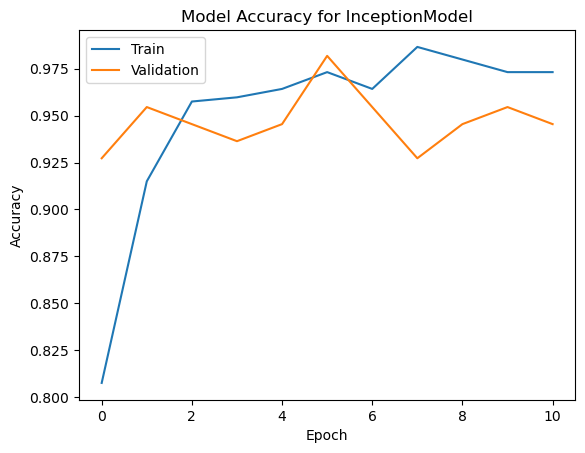

Evaluating InceptionModel...
7/7 [==============================] - 9s 1s/step


9/9 [==============================] - 11s 1s/step


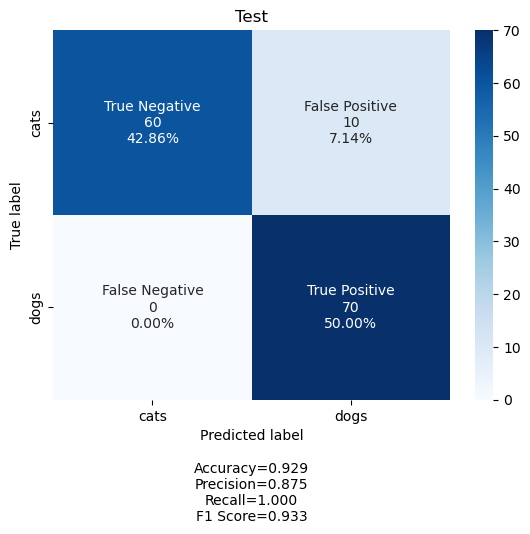

In [15]:
# Build Inception Model
model = InceptionModel()
model.build_transfer_model(epochs=30)
processed_models[model.model_name] = model

In [16]:
# Stash results
testing_results[model.model_name] = model.test_results.T
validation_results[model.model_name] = model.val_results.T

- The accuracy and loss curves track well for training and validation.
- Overall validation accuracy of .964 and test accuracy of .936. Big improvement from the custom and VGG19 model let's look at one final transfer learning model.

### Xception Model
https://keras.io/api/applications/xception/

Training XceptionModel...
Found 447 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 3.7532 - accuracy: 0.8613
Epoch 1: val_accuracy improved from -inf to 0.93636, saving model to dogs_and_cats_XceptionModel


28/28 [==============================] - 54s 2s/step - loss: 3.7532 - accuracy: 0.8613 - val_loss: 1.1243 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 2.0510 - accuracy: 0.9284
Epoch 2: val_accuracy did not improve from 0.93636
28/28 [==============================] - 59s 2s/step - loss: 2.0510 - accuracy: 0.9284 - val_loss: 2.2722 - val_accuracy: 0.9273 - lr: 0.0010
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 1.3908 - accuracy: 0.9508
Epoch 3: val_accuracy did not improve from 0.93636

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
28/28 [==============================] - 60s 2s/step - loss: 1.3908 - accuracy: 0.9508 - val_loss: 1.1773 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 4/30
28/28 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.9732
Epoch 4: val_accuracy did not improve from 0.93636
28/28 [==============================] - 59s 2s/step - loss: 

28/28 [==============================] - 69s 2s/step - loss: 0.1297 - accuracy: 0.9799 - val_loss: 1.2622 - val_accuracy: 0.9455 - lr: 1.0000e-05
Epoch 7/30
28/28 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.9776
Epoch 7: val_accuracy improved from 0.94545 to 0.95455, saving model to dogs_and_cats_XceptionModel


28/28 [==============================] - 73s 3s/step - loss: 0.3059 - accuracy: 0.9776 - val_loss: 0.7897 - val_accuracy: 0.9545 - lr: 1.0000e-05
Epoch 8/30
28/28 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.9776
Epoch 8: val_accuracy did not improve from 0.95455
28/28 [==============================] - 67s 2s/step - loss: 0.3465 - accuracy: 0.9776 - val_loss: 2.0882 - val_accuracy: 0.9182 - lr: 1.0000e-05
Epoch 9/30
28/28 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.9776
Epoch 9: val_accuracy did not improve from 0.95455

Epoch 9: ReduceLROnPlateau reducing learning rate to 1e-05.
28/28 [==============================] - 68s 2s/step - loss: 0.3554 - accuracy: 0.9776 - val_loss: 0.9122 - val_accuracy: 0.9545 - lr: 1.0000e-05
Epoch 10/30
28/28 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.9687
Epoch 10: val_accuracy improved from 0.95455 to 0.97273, saving model to dogs_and_cats_XceptionModel


28/28 [==============================] - 77s 3s/step - loss: 0.3717 - accuracy: 0.9687 - val_loss: 0.7822 - val_accuracy: 0.9727 - lr: 1.0000e-05
Epoch 11/30
28/28 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.9687
Epoch 11: val_accuracy did not improve from 0.97273
28/28 [==============================] - 68s 2s/step - loss: 0.3059 - accuracy: 0.9687 - val_loss: 1.0231 - val_accuracy: 0.9273 - lr: 1.0000e-05
Epoch 12/30
28/28 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.9754
Epoch 12: val_accuracy did not improve from 0.97273
28/28 [==============================] - 68s 2s/step - loss: 0.2889 - accuracy: 0.9754 - val_loss: 0.5244 - val_accuracy: 0.9455 - lr: 1.0000e-05
Epoch 13/30
28/28 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.9776
Epoch 13: val_accuracy did not improve from 0.97273
28/28 [==============================] - 68s 2s/step - loss: 0.4312 - accuracy: 0.9776 - val_loss: 0.8045 - val_accuracy:

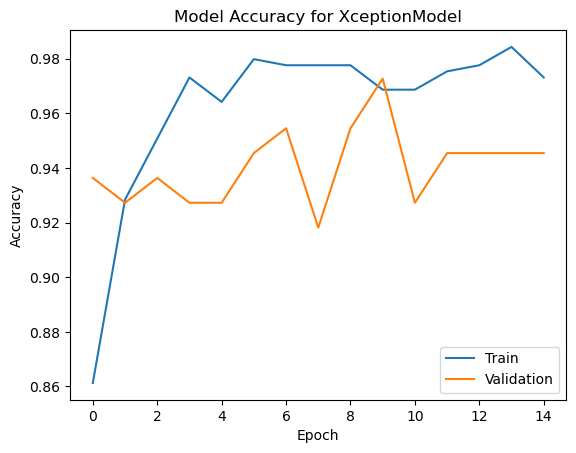

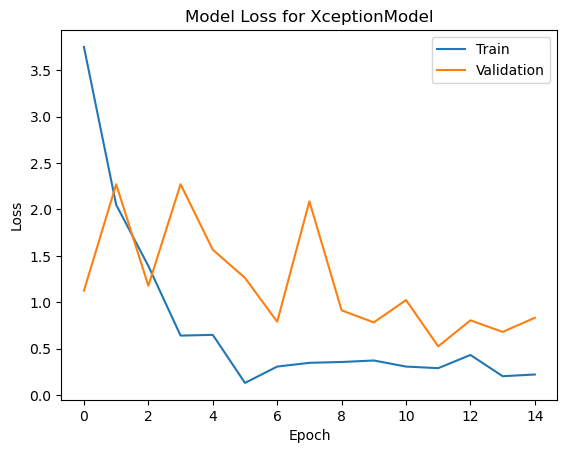

Evaluating XceptionModel...
7/7 [==============================] - 11s 2s/step


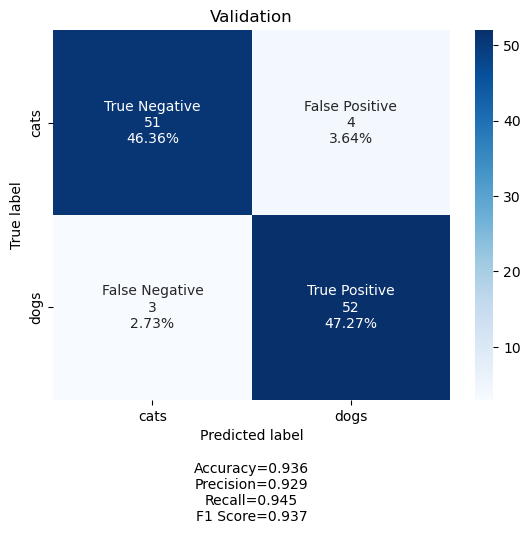

9/9 [==============================] - 13s 1s/step


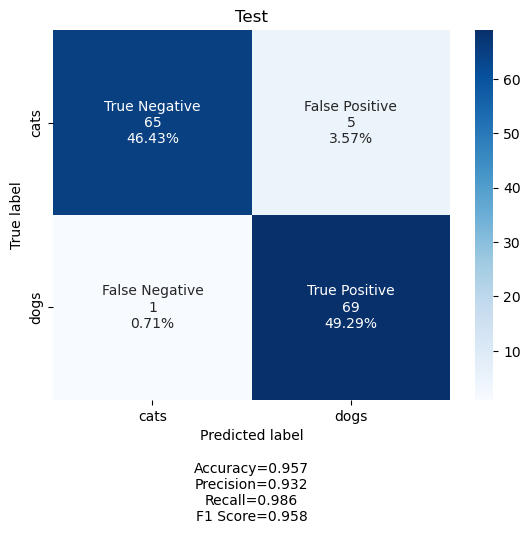

In [17]:
# Build Xception model
model = XceptionModel()
model.build_transfer_model(epochs=30)
processed_models[model.model_name] = model

In [18]:
# Stash results
testing_results[model.model_name] = model.test_results.T
validation_results[model.model_name] = model.val_results.T

- The accuracy and loss curves track well for training and validation.
- Overall validation accuracy of .955 and test accuracy of .964. This is the best test accuracy for a model beating out Inception even though Inception had a slightly higher validation accuracy.

## Overall Results

In [19]:
# validation performance comparison
models_val_comp_df = get_performance_results(validation_results, 'Validation')
models_val_comp_df

In [20]:
# testing performance comparison
models_testing_comp_df = get_performance_results(testing_results, 'Test')
models_testing_comp_df

## Final Model
Given the highest accuracy of 96.4% on the Test dataset the Xception Model had the highest accuracy even though Inception had slightly higher validation accuracy. Let's test it with a few random images

Found 140 images belonging to 2 classes.


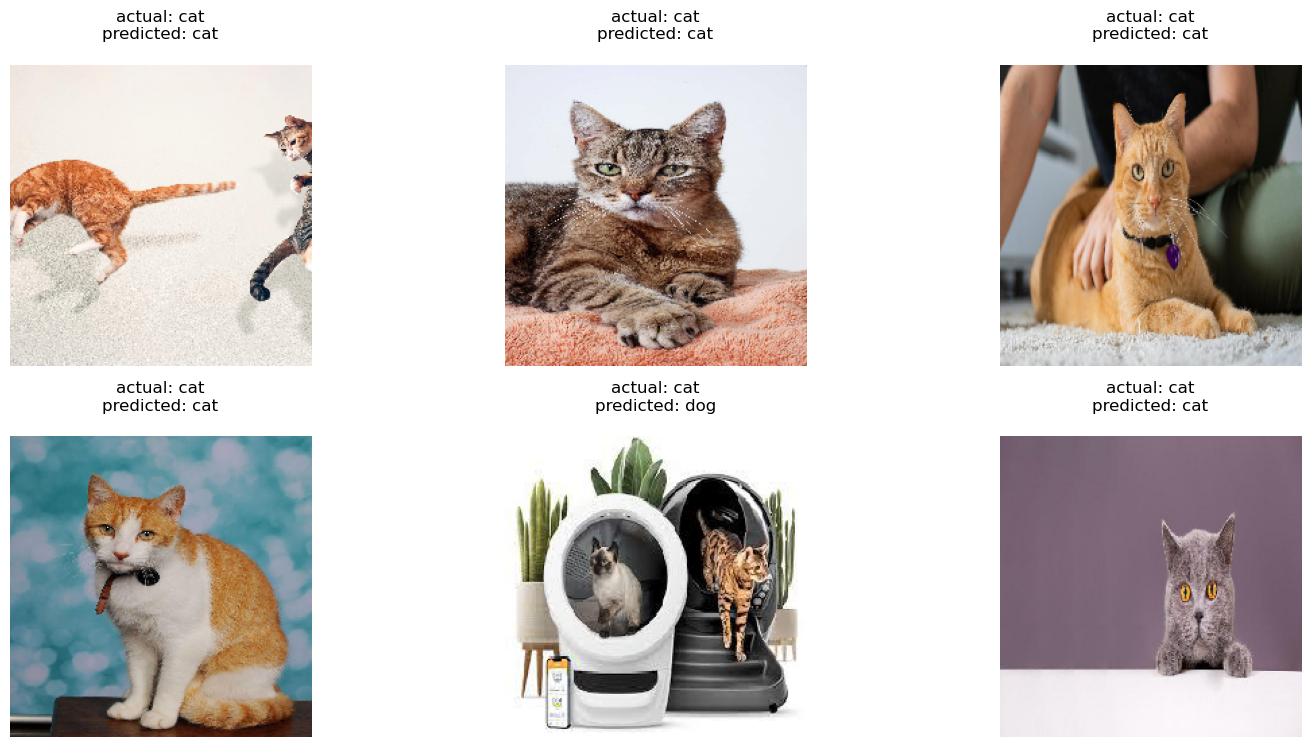

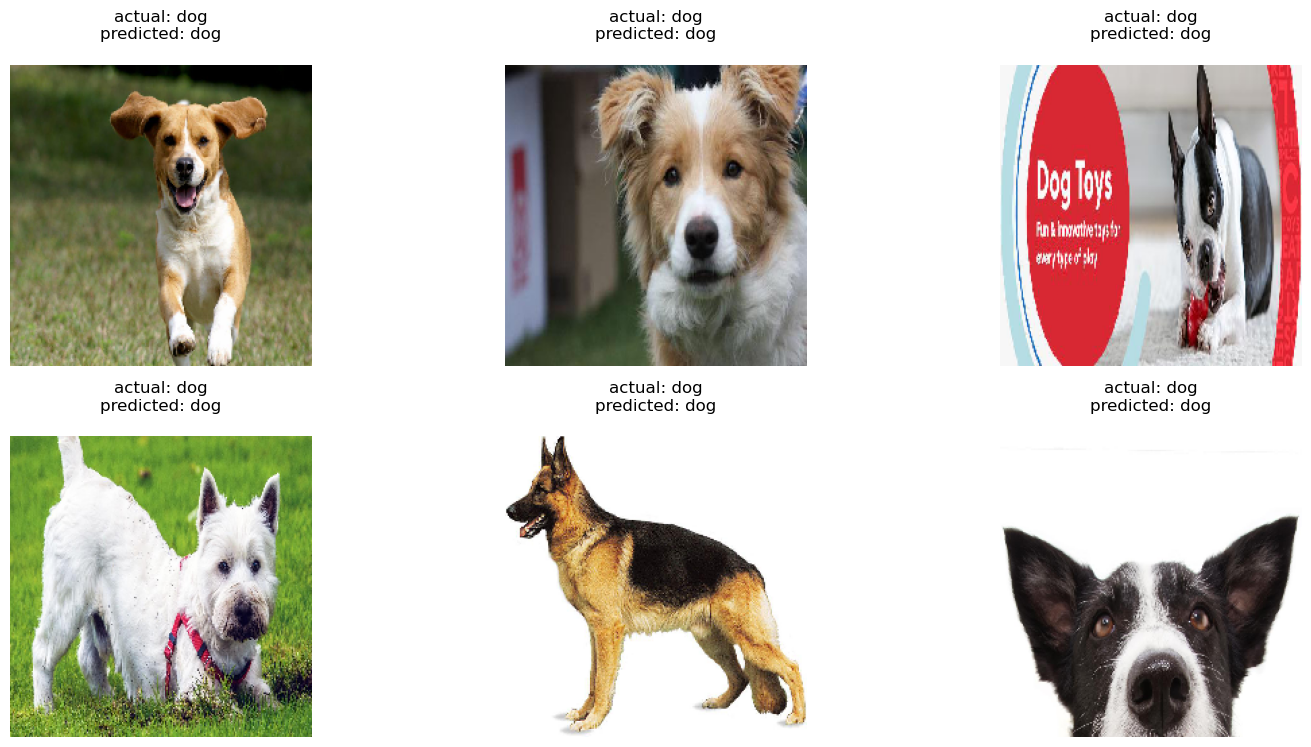

In [21]:
img_height = 224
img_width = 224
batch_size =128
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        classes=['cats', 'dogs'],
        seed=seed
    )
plot_sample_images(test_generator, predicted_classes = processed_models['XceptionModel'].y_pred_test)